# Causal Analysis with doWhy

In this example we take a first look at estimating the causal effect from a generated dataset.
To keep things simple, we use the built-in generator of the doWhy package to create
a small dataset that contains linear relationships between the variables and the outcome
and then use the package to estimate the causal effect.

We will look at two methods to measure the causal effect:
* linear regression
* Propensity Score matching.


N.B. This example follows the documentation from the doWhy package

### Reminders:
We remind ourselves of the following before looking at the example:

* ATE (Average Treatment Effect): This is the average effect of the treatment on the outcome at the population level. 
* ATT (Average Treatment effect among the Treated): This is the effect the treatment has on the outcome among those who received the treatment. 
* ATC (Average Treatment effect on Control): This is the counterpart to ATT looking at the control group.
* Propensity Score (PS): The PS specifies the probability for an individual to receive the treatment. In a random controlled trial (RCT), we assign the individuals to treatment and control group randomly. If this happens with equal probability, the PS is 0.5. However, in observational studies, we cannot control who is in which group and hence there groups may be different as individuals have different probabilities to be "assigned" to treatment or control group. Weighting by the propensity score or matching groups with equal propensity groups allows we can control for the non-random assignment to treatment and control groups. Hence the general idea behind using propensity scores is to approximate a random experiment from observational data.
* Instrumental Variables (IV): IV are a statistical tool that address a specific issue in the use of observational data. Since we cannot through the design of a study ensure that all causal effects are controlled externally, for example by randomly assigning the treatment,  we may have some intrinsic characteristic of the individuals that are related to the outcome. For example, in a simple least squares model, the outcome $y$ may depend on a single variable $x$, i.e. $y = a \cdot x + u$ where $u$ is an error term. Through linear regression we obtain the parameter $a$. However, we assume that the error term $u$ is uncorrelated to $x$. In some cases, depending on the study and the observational data, the assumption that $u$ has no association with $x$ may not hold and in these cases $u$ is associated with both $y$ and $x$ and hence the linear regression estimate for $a$ becomes biased as it now also incoporates the variation of $u$ with the variable $x$ and not just $a$. The idea behind instrumental variables is to introduce another variable $z$ that is only associated with $x$ but not with the error term $u$. Since $z$ is then uncorrelated with $u$, it can be used to measure the causal effect in the case where $x$ is associated with $u$.




In [1]:
#import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets

from IPython.display import Image, display

## Generate Data

We now use the built-in model to create a small dataset that contains only linear relationships between the variables, the treatment and the outcome. In reality, this would correspond to the data we measure.

In this method, ```beta``` is the causal effect we wish to recover from the estimation procedure.

In the nomenclature of the doWhy package, we have:
* v0: The treatment. In this example, we use a binary treatment (e.g. take a medicine or not). In general, this can be a real-valued number (e.g. dosage of the medicine given)
* y: The outcome.

We use a simple model where we have:
* Two common causes that are associated with both the treatment v0 and the outcome y, given by w0 and w1.
* One instrumental variable z0 to account for any case where the treatment is associated with any unobserved error terms
* One variable x0 that is associated with the outcome only.
* We assume that there are unobserved confounders that affect both treatment and outcome, hence the use of instrumental variables.

Note that this method also returns the causal graph which is used to generate the data with. In a real setting we would have to specify this graph ourselves.

In [14]:
data = dowhy.datasets.linear_dataset(beta=7,
        num_common_causes=2,
        num_instruments = 1,
        num_effect_modifiers=1,
        num_samples=10000, 
        treatment_is_binary=True,
        num_discrete_common_causes=0)

Copy the numerical data into a pandas dataframe as this is the format the doWhy package receives the data.

In [15]:
df = data["df"]
df.head()

,X0,Z0,W0,W1,v0,y
0,-0.572023,1.0,0.532748,0.027358,True,6.512455
1,-0.234966,1.0,0.953023,1.335890,True,9.059624
2,0.586273,1.0,-0.270576,0.783228,True,8.743286
3,-1.764275,1.0,0.675793,-0.293687,True,4.201130
4,-0.946250,1.0,-0.789069,0.752243,True,5.649539


## Create Causal Model

We now create the causal model. The pandas dataframe ```df``` contains the data, in our case the date we have generated earlier. We need to tell the model which variable corresponds to the treatment and the outcome as well as the causal graph we have created to describe the dataset.

In [16]:
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


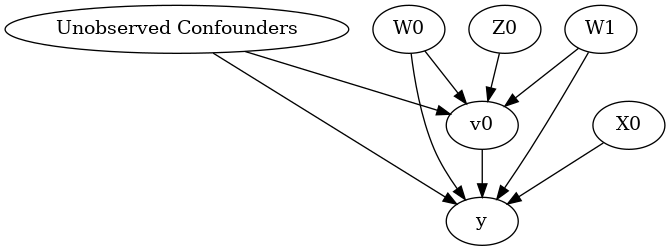

In [17]:
# method creates a png with name 'causal_model.png'. This is hard-coded in the source
# hence we create the file and then load it into the notebook.
model.view_model()
display(Image(filename='causal_model.png'))

## Causal Analysis

We now proceeed with the causal analysis using the doWhy package.

The first step is to make sure that we can identify the effect. 
The warning below reminds us that in observational data we may have confounders that we have not accounted for in our model as explicit variables. We ignore the warning and proceed.

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                           
─────(Expectation(y|W1,X0,W0))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,X0,W0,U) = P(y|v0,W1,X0,W0)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
  d                        
─────(Expectation(y|W1,W0))
d[v₀]                      
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 3
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0])*Derivative([v0], [Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 4
Estimand name: frontdoor
No such variable found!



### Linear Regression

We now use linear regression to estimate the causal effect.
Remember that we wish to recover the value of ```beta``` we have used when generating the dataset.

Using the causal graph, the linear regression model is identified as ```y~v0+W1+W0+v0*X0``` automatically.

In [19]:
#linear regression

causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)

print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:b: y~v0+W1+X0+W0+v0*X0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W1+X0+W0+v0*X0
Target units: ate

## Estimate
Mean value: 6.599532556772235
p-value: [0.]
### Conditional Estimates
__categorical__X0
(-3.73, -1.073]      4.231275
(-1.073, -0.488]     5.708756
(-0.488, 0.00984]    6.592404
(0.00984, 0.609]     7.503026
(0.609, 3.694]       8.962202
dtype: float64
Causal Estimate is 6.599532556772235


Observe if the resulting number is very close to the value ```beta=7``` we used to generate the data.

### Propensity Score

We now use the propensity score to estimate the causal effect.
The regression model is identified automatically as ```y~v0+W1+W0```

In [20]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+X0+W0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W1+X0+W0
Target units: ate

## Estimate
Mean value: 6.601188678020272

Causal Estimate is 6.601188678020272


/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


Again observe if the result is very close to the value ```beta=7``` we used to generate the data with.